### Import Libraries and Read in Data

In [2]:
import numpy as np 
import pandas as pd
import spacy
import nltk
import string
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
# from contractions import CONTRACTION_MAP
import unicodedata
from wordcloud import STOPWORDS
import gc
import re
import string
import operator
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [5]:
# Read in fully wrangled data

df = pd.read_csv("../input/cs366-full-data/wrangled_full_dataset.csv", index_col=0)

### Keeping only "title" because we have too much missing "text" data

In [6]:
df['title'] = df['title'].replace({'missing':np.nan})
df['text'] = df['text'].replace({'missing':np.nan})

In [7]:
del df['text']

In [8]:
df['title'].fillna('missing', inplace=True)

### Preprocessing

In [9]:
# Stripping HTML tags

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [10]:
# Removing accented characters

def remove_accent_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [11]:
# Removing Special Characters

def remove_spec_chars(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

In [12]:
# Lemmatize text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [13]:
# Removing Stopwords

def remove_stopwords(text, is_lower_case=False):
    
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [14]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
            
        # remove accented characters
        if accented_char_removal:
            doc = remove_accent_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
            
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
            
        # remove special characters    
        if special_char_removal:
            doc = remove_spec_chars(doc)  
            
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus[0]

In [15]:
# new_text = []

# for doc in df['text']:
#     new_text.append(normalize_corpus([doc], text_lemmatization=False, stopword_removal=False, text_lower_case=False))

In [16]:
new_title = []

for doc in df['title']:
    new_title.append(normalize_corpus([doc], text_lemmatization=False, stopword_removal=False, text_lower_case=False))

In [17]:
# df['text'] = pd.Series(new_text)
df['title'] = pd.Series(new_title)

### Basic Meta Feature Creation

In [18]:
df['url_len'] = np.where(df['url']=='missing', 0, df['url'].apply(lambda x: len(x)))

In [20]:
# word_count
df['title_wc'] = df['title'].apply(lambda x: len(str(x).split()))
df['title_wc'] = np.where(df['title']=='missing', 0, df['title_wc'])

# unique_word_count
df['title_unique_wc'] = df['title'].apply(lambda x: len(set(str(x).split())))
df['title_unique_wc'] = np.where(df['title']=='missing', 0, df['title_unique_wc'])

# stop_word_count
df['title_stop_wc'] = df['title'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df['title_stop_wc'] = np.where(df['title']=='missing', 0, df['title_stop_wc'])

# mean_word_length
df['title_mean_wl'] = df['title'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['title_mean_wl'] = np.where(df['title']=='missing', 0, df['title_mean_wl'])

# median_word_length
df['title_median_wl'] = df['title'].apply(lambda x: np.median([len(w) for w in str(x).split()]))
df['title_median_wl'] = np.where(df['title']=='missing', 0, df['title_median_wl'])

# char_count
df['title_cc'] = df['title'].apply(lambda x: len(str(x)))
df['title_cc'] = np.where(df['title']=='missing', 0, df['title_cc'])

# # punctuation_count
# df['title_pc'] = df['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# df['title_pc'] = np.where(df['title']=='missing', 0, df['title_pc'])

# # hashtag_count
# df['title_hc'] = df['title'].apply(lambda x: len([c for c in str(x) if c == '#']))
# df['title_hc'] = np.where(df['title']=='missing', 0, df['title_hc'])

# # mention_count
# df['title_mc'] = df['title'].apply(lambda x: len([c for c in str(x) if c == '@']))
# df['title_mc'] = np.where(df['title']=='missing', 0, df['title_mc'])

In [ ]:
df.to_csv("data_meta_feat_added.csv")

### Class Distribution

In [21]:
# Dividing data into real, fake and sarcasm data for easier n-gram visualizations

df_real = df.copy()[df.target=='real']
df_fake = df.copy()[df.target=='fake']
df_sarc = df.copy()[df.target=='sarcasm']

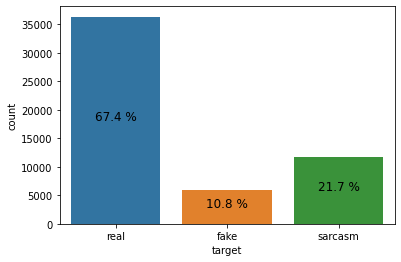

In [22]:
bars = sns.countplot(data=df, x='target')

for bar in bars.patches:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, str(round(int(bar.get_height())*100/len(df),1)) + ' %', ha='center', color='black', fontsize=12)

Class distribution is very skewed towards real news, so we might need to do some resampling to resolve class imbalance issue

### Distribution of Number of characters in Title 

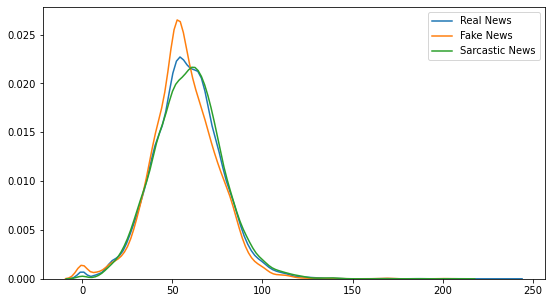

In [23]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_real['title_cc'], ax=ax) 
sns.kdeplot(df_fake['title_cc'], ax=ax)
sns.kdeplot(df_sarc['title_cc'], ax=ax)
plt.legend(['Real News', 'Fake News', 'Sarcastic News'])

### Distribution of Number of Words

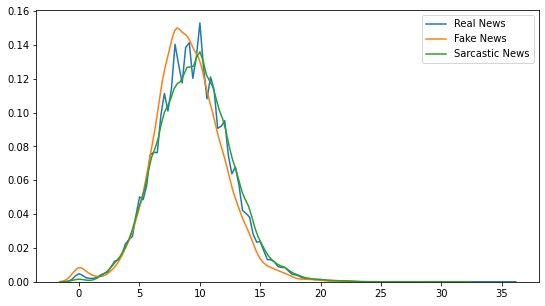

In [24]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_real['title_unique_wc'], ax=ax) 
sns.kdeplot(df_fake['title_unique_wc'], ax=ax)
sns.kdeplot(df_sarc['title_unique_wc'], ax=ax)
plt.legend(['Real News', 'Fake News', 'Sarcastic News'])

### Distribution of Word Count

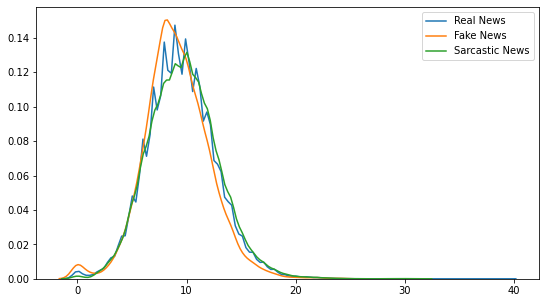

In [25]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_real['title_wc'], ax=ax) 
sns.kdeplot(df_fake['title_wc'], ax=ax)
sns.kdeplot(df_sarc['title_wc'], ax=ax)
plt.legend(['Real News', 'Fake News', 'Sarcastic News'])

### Distribution of Average Word Length

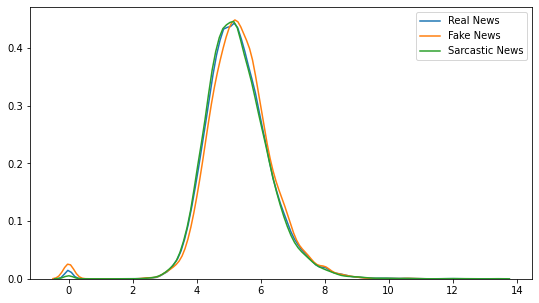

In [26]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_real['title_mean_wl'], ax=ax) 
sns.kdeplot(df_fake['title_mean_wl'], ax=ax)
sns.kdeplot(df_sarc['title_mean_wl'], ax=ax)
plt.legend(['Real News', 'Fake News', 'Sarcastic News'])

### Distribution of Median Word Length

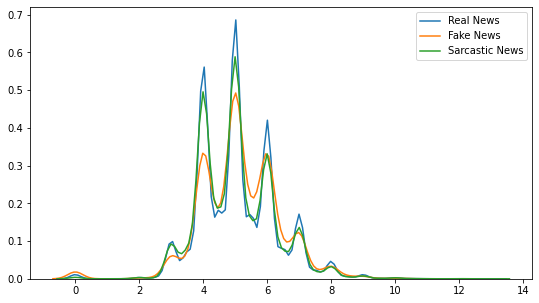

In [27]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_real['title_median_wl'], ax=ax) 
sns.kdeplot(df_fake['title_median_wl'], ax=ax)
sns.kdeplot(df_sarc['title_median_wl'], ax=ax)
plt.legend(['Real News', 'Fake News', 'Sarcastic News'])

### Top N unigram, bigram and trigram viz by type of text (e.g. real, fake and sarcasm)

In [28]:
# Generating ngrams

def ngram_gen(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [29]:
# Unigrams
real_title_unigrams = defaultdict(int)
fake_title_unigrams = defaultdict(int)
sarc_title_unigrams = defaultdict(int)

for tweet in df_real['title']:
    for word in ngram_gen(tweet):
        real_title_unigrams[word] += 1

for tweet in df_fake['title']:
    for word in ngram_gen(tweet):
        fake_title_unigrams[word] += 1

for tweet in df_sarc['title']:
    for word in ngram_gen(tweet):
        sarc_title_unigrams[word] += 1

df_real_title_unigrams = pd.DataFrame(sorted(real_title_unigrams.items(), key=lambda x: x[1])[::-1])
df_fake_title_unigrams = pd.DataFrame(sorted(fake_title_unigrams.items(), key=lambda x: x[1])[::-1])
df_sarc_title_unigrams = pd.DataFrame(sorted(sarc_title_unigrams.items(), key=lambda x: x[1])[::-1])

# df_real_title_unigrams[1] = df_real_title_unigrams[1] * 100 / len(df_real)
# df_fake_title_unigrams[1] = df_fake_title_unigrams[1] * 100 / len(df_fake)
# df_sarc_title_unigrams[1] = df_sarc_title_unigrams[1] * 100 / len(df_sarc)

In [30]:
# Bigrams
real_title_bigrams = defaultdict(int)
fake_title_bigrams = defaultdict(int)
sarc_title_bigrams = defaultdict(int)

for tweet in df_real['title']:
    for word in ngram_gen(tweet, n_gram=2):
        real_title_bigrams[word] += 1

for tweet in df_fake['title']:
    for word in ngram_gen(tweet, n_gram=2):
        fake_title_bigrams[word] += 1

for tweet in df_sarc['title']:
    for word in ngram_gen(tweet, n_gram=2):
        sarc_title_bigrams[word] += 1

df_real_title_bigrams = pd.DataFrame(sorted(real_title_bigrams.items(), key=lambda x: x[1])[::-1])
df_fake_title_bigrams = pd.DataFrame(sorted(fake_title_bigrams.items(), key=lambda x: x[1])[::-1])
df_sarc_title_bigrams = pd.DataFrame(sorted(sarc_title_bigrams.items(), key=lambda x: x[1])[::-1])

# df_real_title_bigrams[1] = df_real_title_bigrams[1] * 100 / len(df_real)
# df_fake_title_bigrams[1] = df_fake_title_bigrams[1] * 100 / len(df_fake)
# df_sarc_title_bigrams[1] = df_sarc_title_bigrams[1] * 100 / len(df_sarc)

In [31]:
# Trigrams
real_title_trigrams = defaultdict(int)
fake_title_trigrams = defaultdict(int)
sarc_title_trigrams = defaultdict(int)

for tweet in df_real['title']:
    for word in ngram_gen(tweet, n_gram=3):
        real_title_trigrams[word] += 1

for tweet in df_fake['title']:
    for word in ngram_gen(tweet, n_gram=3):
        fake_title_trigrams[word] += 1

for tweet in df_sarc['title']:
    for word in ngram_gen(tweet, n_gram=3):
        sarc_title_trigrams[word] += 1
        
df_real_title_trigrams = pd.DataFrame(sorted(real_title_trigrams.items(), key=lambda x: x[1])[::-1])
df_fake_title_trigrams = pd.DataFrame(sorted(fake_title_trigrams.items(), key=lambda x: x[1])[::-1])
df_sarc_title_trigrams = pd.DataFrame(sorted(sarc_title_trigrams.items(), key=lambda x: x[1])[::-1])

# df_real_title_trigrams[1] = df_real_title_trigrams[1] * 100 / len(df_real)
# df_fake_title_trigrams[1] = df_fake_title_trigrams[1] * 100 / len(df_fake)
# df_sarc_title_trigrams[1] = df_sarc_title_trigrams[1] * 100 / len(df_sarc)

In [32]:
# Top "20"

N = 20

Text(0.5, 1.0, 'Top 20 most frequent unigrams in Real(left), Fake(middle), and Sarcastic(right) News')

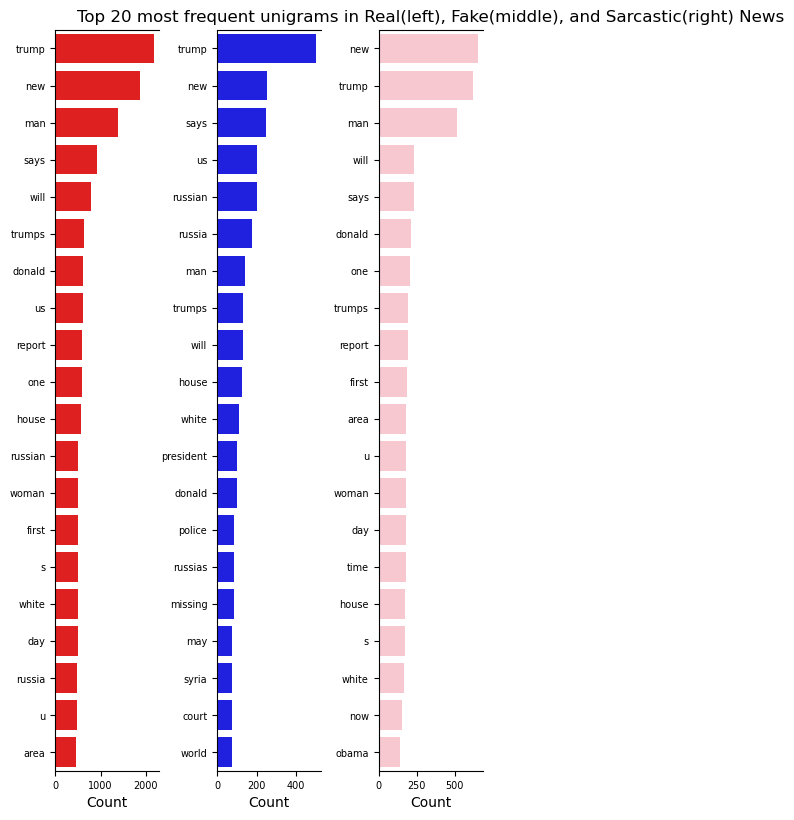

In [33]:
# Unigram Visualization

fig, axes = plt.subplots(ncols=3, figsize=(5, 8), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_title_unigrams[0].values[:N], x=df_real_title_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_title_unigrams[0].values[:N], x=df_fake_title_unigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=df_sarc_title_unigrams[0].values[:N], x=df_sarc_title_unigrams[1].values[:N], ax=axes[2], color='pink')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)

plt.title("Top 20 most frequent unigrams in Real(left), Fake(middle), and Sarcastic(right) News")

# axes[0].set_title(f'Top {N} most common unigrams in Real News', fontsize=8)
# axes[1].set_title(f'Top {N} most common unigrams in Fake News', fontsize=8)
# axes[2].set_title(f'Top {N} most common unigrams in Sarcastic News', fontsize=8)

Text(0.5, 1.0, 'Top 20 most frequent bigrams in Real(left), Fake(middle), and Sarcastic(right) News')

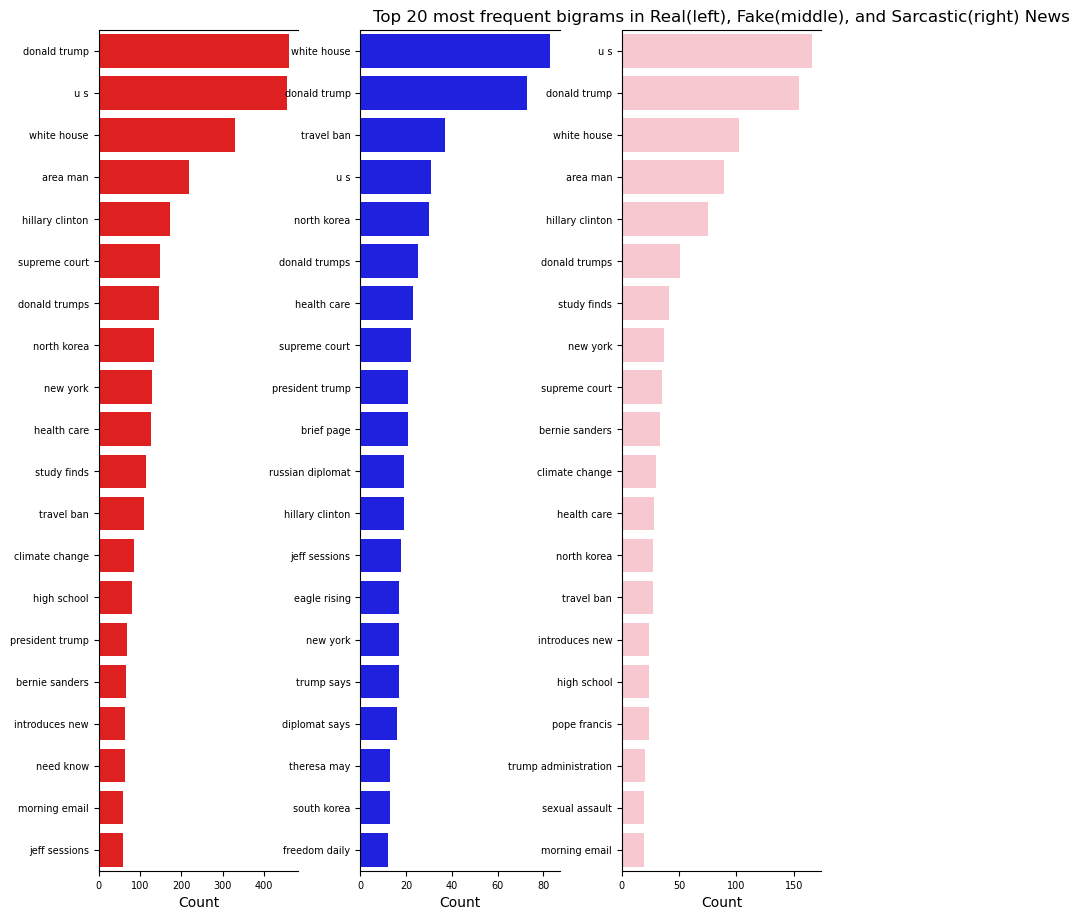

In [34]:
# Bigram Visualization

fig, axes = plt.subplots(ncols=3, figsize=(8, 9), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_title_bigrams[0].values[:N], x=df_real_title_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_title_bigrams[0].values[:N], x=df_fake_title_bigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=df_sarc_title_bigrams[0].values[:N], x=df_sarc_title_bigrams[1].values[:N], ax=axes[2], color='pink')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)

plt.title("Top 20 most frequent bigrams in Real(left), Fake(middle), and Sarcastic(right) News")
# axes[0].set_title(f'Top {N} most common bigrams in Real News', fontsize=8)
# axes[1].set_title(f'Top {N} most common bigrams in Fake News', fontsize=8)
# axes[2].set_title(f'Top {N} most common bigrams in Sarcastic News', fontsize=8)

Text(0.5, 1.0, 'Top 20 most frequent trigrams in Real(left), Fake(middle), and Sarcastic(right) News')

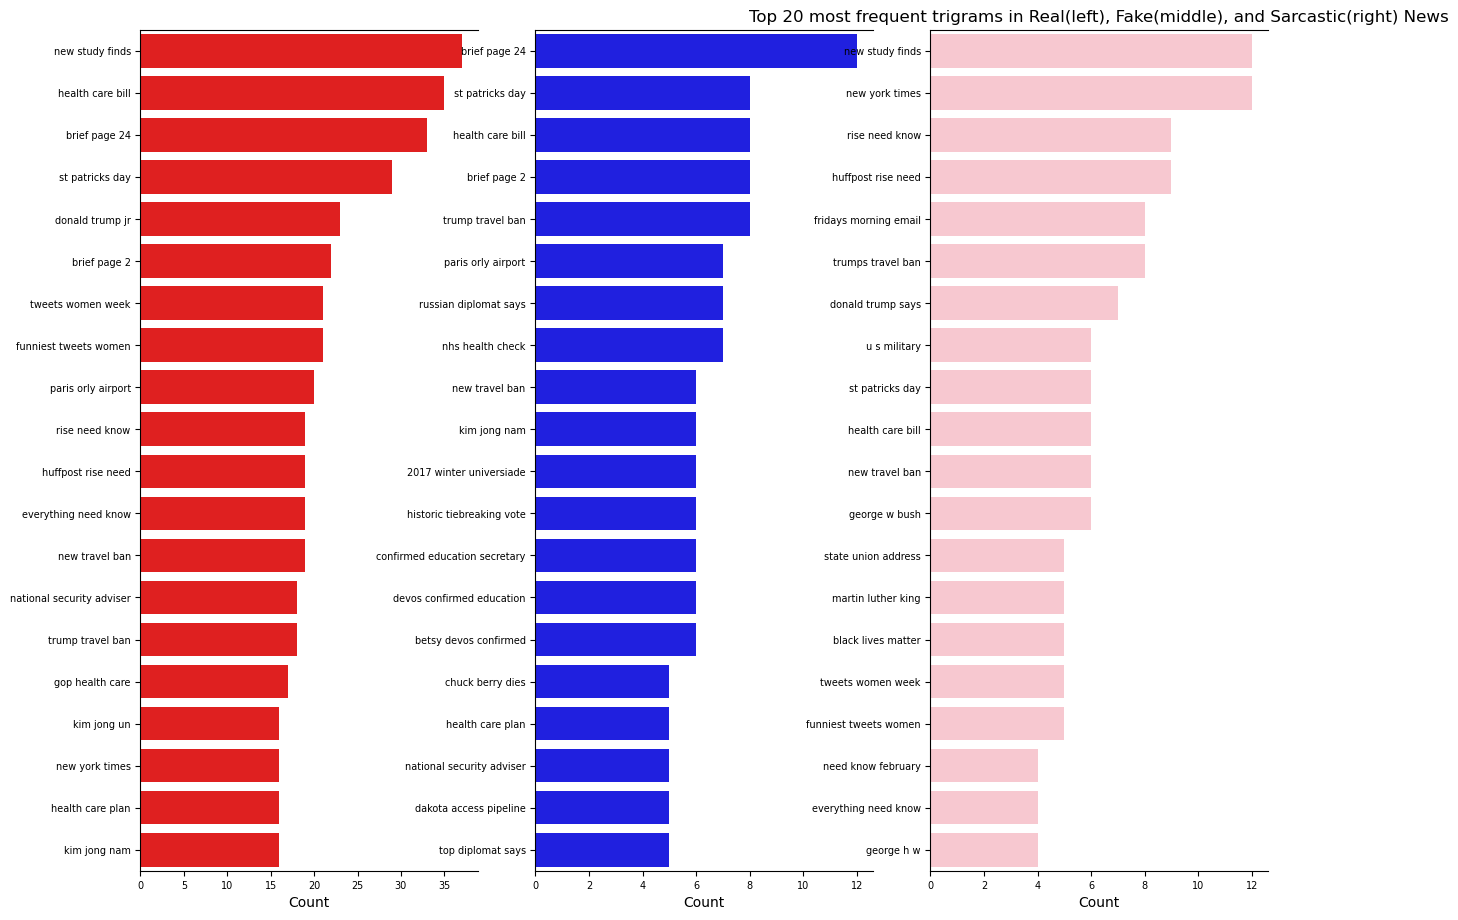

In [35]:
# Trigram Visualization

fig, axes = plt.subplots(ncols=3, figsize=(12, 9), dpi=100)
plt.tight_layout()

sns.barplot(y=df_real_title_trigrams[0].values[:N], x=df_real_title_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_fake_title_trigrams[0].values[:N], x=df_fake_title_trigrams[1].values[:N], ax=axes[1], color='blue')
sns.barplot(y=df_sarc_title_trigrams[0].values[:N], x=df_sarc_title_trigrams[1].values[:N], ax=axes[2], color='pink')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)

plt.title("Top 20 most frequent trigrams in Real(left), Fake(middle), and Sarcastic(right) News")
# axes[0].set_title(f'Top {N} most common trigrams in Real News', fontsize=8)
# axes[1].set_title(f'Top {N} most common trigrams in Fake News', fontsize=8)
# axes[2].set_title(f'Top {N} most common trigrams in Sarcastic News', fontsize=8)

### WordCloud

CPU times: user 40.3 s, sys: 330 ms, total: 40.6 s
Wall time: 41.2 s


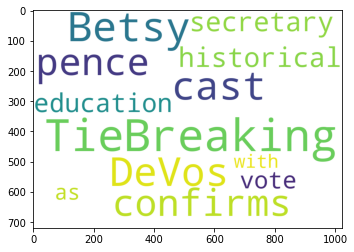

In [36]:
### Real New Data WordCloud based on TFIDF

%%time

# import sys
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from wordcloud import WordCloud
from collections import defaultdict

def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

stemmer = PorterStemmer() # Stemmer for reducing terms to root form 

stemmed_corpus = []       # For storing the stemmed tokens 

original_corpus = []      # For storing the non-stemmed tokens


for contents in df_real['title']:                # Iterate over title column

    tokens = word_tokenize(contents)     # Extract tokens

    stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens


    stemmed_corpus.append(stemmed)    # Store stemmed document

    original_corpus.append(tokens)    # Store original document
    
dictionary = Dictionary(stemmed_corpus) # Build the dictionary

# Get the surface form for each stemmed word

counts = get_common_surface_form(original_corpus, stemmer)

# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Get TF-IDF weights

weights = tfidf[vectors[0]]

# Replace term IDs with human consumable strings

weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]

# Initialize the cloud

wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stopwords.words('english')
)

# Generate the cloud
plt.imshow(wc.fit_words(dict(weights)))

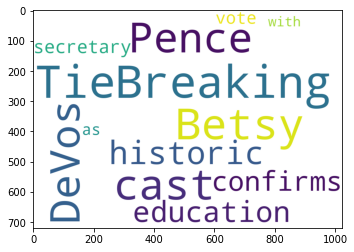

In [41]:
stemmer = PorterStemmer() # Stemmer for reducing terms to root form 

stemmed_corpus = []       # For storing the stemmed tokens 

original_corpus = []      # For storing the non-stemmed tokens


for contents in df_fake['title']:                # Iterate over title column

    tokens = word_tokenize(contents)     # Extract tokens

    stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens


    stemmed_corpus.append(stemmed)    # Store stemmed document

    original_corpus.append(tokens)    # Store original document
    
dictionary = Dictionary(stemmed_corpus) # Build the dictionary

# Get the surface form for each stemmed word

counts = get_common_surface_form(original_corpus, stemmer)

# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Get TF-IDF weights

weights = tfidf[vectors[0]]

# Replace term IDs with human consumable strings

weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]

# Initialize the cloud

#from PIL import Image
# mask = np.array(Image.open("../input/fake-news-photo/fake news.jpg"))

wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stopwords.words('english')
)

# Generate the cloud
plt.imshow(wc.fit_words(dict(weights)))

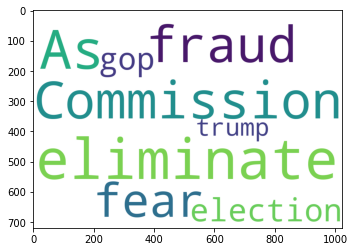

In [42]:
### Sarcastic News

stemmer = PorterStemmer() # Stemmer for reducing terms to root form 

stemmed_corpus = []       # For storing the stemmed tokens 

original_corpus = []      # For storing the non-stemmed tokens


for contents in df_sarc['title']:                # Iterate over title column

    tokens = word_tokenize(contents)     # Extract tokens

    stemmed = [stemmer.stem(token) for token in tokens] # Stem tokens


    stemmed_corpus.append(stemmed)    # Store stemmed document

    original_corpus.append(tokens)    # Store original document
    
dictionary = Dictionary(stemmed_corpus) # Build the dictionary

# Get the surface form for each stemmed word

counts = get_common_surface_form(original_corpus, stemmer)

# Convert to vector corpus

vectors = [dictionary.doc2bow(text) for text in stemmed_corpus]

# Train TF-IDF model

tfidf = TfidfModel(vectors)

# Get TF-IDF weights

weights = tfidf[vectors[0]]

# Replace term IDs with human consumable strings

weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]

# Initialize the cloud

#from PIL import Image
# mask = np.array(Image.open("../input/fake-news-photo/fake news.jpg"))

wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stopwords.words('english')
)

# Generate the cloud
plt.imshow(wc.fit_words(dict(weights)))